# 1. Bài toán Regression
**Mục tiêu**: Dự đoán `price_usd` tại mốc **t+1** của *chính coin đó* dựa trên dữ liệu tại mốc **t** và các đặc trưng trễ (lag).

**Dữ liệu đầu vào**: `processed_cryptotocurrency.csv`
- Cột chính: timestamp, name, symbol, price_usd, vol_24h, total_vol, chg_24h, chg_7d, market_cap, name_encoded
- Mỗi dòng: trạng thái của một `symbol` tại 1 mốc `timestamp` (panel time-series)

**Chiến lược**:
1) Tạo nhãn `price_t+1 = shift(-1)` theo từng `symbol`
2) Tạo lag features: `price_t-1`, `price_t-2`, rolling mean `ma_3`, `ma_7`, momentum `mom_1`
3) Chia train/test **theo thời gian**
4) Huấn luyện: Linear Regression (baseline) vs Random Forest (phi tuyến)
5) Đánh giá: MAE, RMSE, R²; Feature Importance; biểu đồ `y_true` vs `y_pred`


## I. Cài đặt thư viện cần thiết

In [42]:
# !pip install pandas numpy scikit-learn matplotlib xgboost -q

import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Plot
import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

##II. Nạp dữ liệu & kiểm tra

In [43]:
CSV_PATH = "processed_cryptotocurrency.csv"  # đổi path nếu cần
assert Path(CSV_PATH).exists(), f"Không tìm thấy file: {CSV_PATH}"

df = pd.read_csv(CSV_PATH)

expected_cols = [
    'timestamp','name','symbol','price_usd','vol_24h','total_vol',
    'chg_24h','chg_7d','market_cap','name_encoded'
]
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Thiếu các cột bắt buộc: {missing}")

# Chuẩn hoá thời gian & sort theo coin + thời gian
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['symbol','timestamp']).reset_index(drop=True)

print("Kích thước:", df.shape)
print("Số symbol:", df['symbol'].nunique())
print("Số mốc thời gian duy nhất:", df['timestamp'].nunique())
display(df.head(10))
print("Thiếu giá trị tổng:", df.isna().sum().sum())


Kích thước: (170430, 10)
Số symbol: 287
Số mốc thời gian duy nhất: 6318


,timestamp,name,symbol,price_usd,vol_24h,total_vol,chg_24h,chg_7d,market_cap,name_encoded
0,2025-04-10 10:36:00,0G,0g,3.07,328906282.0,0.0010,0.0277,-0.1897,656448544.0,0
1,2025-04-10 10:39:00,0G,0g,3.07,326561005.0,0.0009,0.0200,-0.1919,653965794.0,0
2,2025-04-10 10:52:00,0G,0g,3.05,219867828.0,0.0006,0.0030,-0.1963,650369931.0,0
3,2025-04-10 11:26:00,0G,0g,3.05,215138181.0,0.0006,0.0184,-0.2222,650026571.0,0
4,2025-04-10 11:43:00,0G,0g,3.04,313025756.0,0.0009,0.0123,-0.2244,647503595.0,0
5,2025-04-10 11:55:00,0G,0g,3.04,213275758.0,0.0006,0.0076,-0.2250,646999743.0,0
6,2025-04-10 10:36:00,1INCH,1inch,0.27,20665604.0,0.0001,0.0060,0.1146,370584575.0,1
7,2025-04-10 10:39:00,1INCH,1inch,0.26,21171651.0,0.0001,0.0053,0.1139,370535023.0,1
8,2025-04-10 10:52:00,1INCH,1inch,0.26,21266382.0,0.0001,0.0009,0.1105,369754386.0,1
9,2025-04-10 11:26:00,1INCH,1inch,0.26,20022779.0,0.0001,-0.0011,0.1079,367670429.0,1


Thiếu giá trị tổng: 0


##III. Tạo nhãn & đặc trưng thời gian ##

- Label: `price_t+1 = shift(-1)` theo từng `symbol`
- Lag features: `price_t-1`, `price_t-2`
- Rolling mean: `ma_3`, `ma_7` (đường trung bình động ngắn hạn)
- Momentum: `mom_1 = price_usd - price_t-1`



In [44]:
g = df.groupby('symbol')
df['timestamp_t+1'] = g['timestamp'].shift(-1)


df['price_t+1'] = g['price_usd'].shift(-1)
df['price_t-1'] = g['price_usd'].shift(1)
df['price_t-2'] = g['price_usd'].shift(2)

# Rolling mean theo từng coin
df['ma_3'] = g['price_usd'].rolling(3).mean().reset_index(level=0, drop=True)
df['ma_7'] = g['price_usd'].rolling(7).mean().reset_index(level=0, drop=True)

# Momentum ngắn hạn
df['mom_1'] = df['price_usd'] - df['price_t-1']

# Loại bỏ các hàng thiếu do shift/rolling
df_model = df.dropna(subset=['price_t+1','price_t-1','price_t-2','ma_3','ma_7','mom_1']).copy()

print("Sau khi tạo features, kích thước:", df_model.shape)
display(df_model[['timestamp','symbol','price_usd','price_t-1','price_t+1','ma_3','ma_7','mom_1']].head(10))

Sau khi tạo features, kích thước: (168722, 17)


,timestamp,symbol,price_usd,price_t-1,price_t+1,ma_3,ma_7,mom_1
24,2025-01-04 07:34:00,ADA,0.6687,0.6704,0.6738,0.668367,0.663900,-0.0017
25,2025-01-04 08:34:00,ADA,0.6738,0.6687,0.6726,0.670967,0.665843,0.0051
26,2025-01-04 09:34:00,ADA,0.6726,0.6738,0.6709,0.671700,0.668229,-0.0012
27,2025-01-04 10:34:00,ADA,0.6709,0.6726,0.6754,0.672433,0.669700,-0.0017
28,2025-01-04 11:34:00,ADA,0.6754,0.6709,0.6814,0.672967,0.671114,0.0045
29,2025-01-04 12:34:00,ADA,0.6814,0.6754,0.6811,0.675900,0.673314,0.0060
30,2025-01-04 13:34:00,ADA,0.6811,0.6814,0.6755,0.679300,0.674843,-0.0003
31,2025-01-04 14:34:00,ADA,0.6755,0.6811,0.6767,0.679333,0.675814,-0.0056
32,2025-01-04 15:34:00,ADA,0.6767,0.6755,0.6737,0.677767,0.676229,0.0012
33,2025-01-04 16:34:00,ADA,0.6737,0.6767,0.6707,0.675300,0.676386,-0.0030


## IV. Chọn tập đặc trưng & chia train/test theo thời gian




In [45]:
# Chọn features
features = [
    'price_t-1','price_t-2','ma_3','ma_7','mom_1',
    'vol_24h','chg_24h','chg_7d','market_cap','name_encoded'
]
target = 'price_t+1'

# (Tuỳ chọn) nếu muốn thử thêm 'total_vol' thì append và đánh giá xem có cải thiện không
# features.append('total_vol')

# Time-based split
cut_time = df_model['timestamp'].quantile(0.80)
train_mask = df_model['timestamp'] <= cut_time
test_mask  = df_model['timestamp'] >  cut_time

X_train = df_model.loc[train_mask, features].copy()
y_train = df_model.loc[train_mask, target].copy()
X_test  = df_model.loc[test_mask,  features].copy()
y_test  = df_model.loc[test_mask,  target].copy()

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Mốc chia thời gian:", cut_time)


Train shape: (135013, 10) | Test shape: (33709, 10)
Mốc chia thời gian: 2025-10-21 22:22:00


## V. Huấn luyện & đánh giá

- Baseline: **Linear Regression**
- Mạnh hơn: **Random Forest Regressor**
- Chỉ số: **MAE**, **RMSE**, **R²**


In [46]:
def evaluate_reg(model, Xtr, ytr, Xte, yte, name="Model"):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    mae  = mean_absolute_error(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    r2   = r2_score(yte, pred)
    print(f"{name}: MAE={mae:,.4f} | RMSE={rmse:,.4f} | R²={r2:.4f}")
    return pred

lr = LinearRegression()
rf = RandomForestRegressor(
    n_estimators=300, max_depth=None, random_state=RANDOM_STATE, n_jobs=-1
)

pred_lr = evaluate_reg(lr, X_train, y_train, X_test, y_test, "Linear (time-split)")
pred_rf = evaluate_reg(rf, X_train, y_train, X_test, y_test, "RandomForest (time-split)")


Linear (time-split): MAE=19.0711 | RMSE=257.1057 | R²=0.9999
RandomForest (time-split): MAE=43.8817 | RMSE=419.1894 | R²=0.9997


In [47]:
def evaluate_reg(model, Xtr, ytr, Xte, yte, name="Model"):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    mae  = mean_absolute_error(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    r2   = r2_score(yte, pred)
    print(f"{name}: MAE={mae:,.4f} | RMSE={rmse:,.4f} | R²={r2:.4f}")
    return pred

# Baseline: dự đoán t+1 bằng chính giá t
y_pred_naive = X_test['price_t-1'].values
mae_n  = mean_absolute_error(y_test, y_pred_naive)
rmse_n = np.sqrt(mean_squared_error(y_test, y_pred_naive))
r2_n   = r2_score(y_test, y_pred_naive)
print(f"NAIVE (y_pred = price_t): MAE={mae_n:,.4f} | RMSE={rmse_n:,.4f} | R²={r2_n:.4f}")

# Models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)

pred_lr = evaluate_reg(lr, X_train, y_train, X_test, y_test, "Linear (time-split)")
pred_rf = evaluate_reg(rf, X_train, y_train, X_test, y_test, "RandomForest (time-split)")


NAIVE (y_pred = price_t): MAE=28.8205 | RMSE=405.5524 | R²=0.9998
Linear (time-split): MAE=19.0711 | RMSE=257.1057 | R²=0.9999
RandomForest (time-split): MAE=43.8817 | RMSE=419.1894 | R²=0.9997


In [48]:
summary = pd.DataFrame([
    {"Model":"Naive (price_t)", "MAE":mae_n, "RMSE":rmse_n, "R2":r2_n},
    {"Model":"Linear (time-split)",
     "MAE":mean_absolute_error(y_test, pred_lr),
     "RMSE":np.sqrt(mean_squared_error(y_test, pred_lr)),
     "R2":r2_score(y_test, pred_lr)},
    {"Model":"RandomForest (time-split)",
     "MAE":mean_absolute_error(y_test, pred_rf),
     "RMSE":np.sqrt(mean_squared_error(y_test, pred_rf)),
     "R2":r2_score(y_test, pred_rf)},
]).sort_values("MAE")

print("📊 Tóm tắt (test set):")
display(summary.style.format({"MAE":"{:.2f}","RMSE":"{:.2f}","R2":"{:.4f}"}))


📊 Tóm tắt (test set):


,Model,MAE,RMSE,R2
1,Linear (time-split),19.07,257.11,0.9999
0,Naive (price_t),28.82,405.55,0.9998
2,RandomForest (time-split),43.88,419.19,0.9997


## VI. Sanity check

- Scatter `y_test` vs `y_pred` để quan sát độ chệch theo thang giá
- Biểu đồ sai số tuyệt đối (Abs Error) để xem đuôi phân phối


In [49]:
viz_cols = ['symbol','timestamp','timestamp_t+1','price_usd','price_t-1',
            'ma_3','ma_7','vol_24h','market_cap']
viz = df_model.loc[test_mask, viz_cols].copy()
viz['y_true_t+1'] = y_test.values
viz['y_pred_rf']  = pred_rf
viz['abs_err']    = (viz['y_true_t+1'] - viz['y_pred_rf']).abs()
viz['pct_err']    = 100 * viz['abs_err'] / (viz['y_true_t+1'].replace(0, np.nan))

print("10 bản ghi minh hoạ (test):")
display(
    viz.sort_values('timestamp', ascending=False).head(10)[
        ['symbol','timestamp','timestamp_t+1','price_usd','y_true_t+1','y_pred_rf','abs_err','pct_err']
    ].style.format({'price_usd':'{:.2f}','y_true_t+1':'{:.2f}','y_pred_rf':'{:.2f}',
                    'abs_err':'{:.2f}','pct_err':'{:.2f}%'})
)

10 bản ghi minh hoạ (test):


,symbol,timestamp,timestamp_t+1,price_usd,y_true_t+1,y_pred_rf,abs_err,pct_err
170422,zec,2025-12-10 23:40:00,2025-12-10 23:52:00,275.40,272.65,270.46,2.19,0.80%
105856,bsc-usd,2025-12-10 23:40:00,2025-12-10 23:52:00,1.00,1.00,1.00,0.00,0.00%
101592,bch,2025-12-10 23:40:00,2025-12-10 23:52:00,543.27,544.58,531.41,13.17,2.42%
149112,usdc,2025-12-10 23:40:00,2025-12-10 23:52:00,1.00,1.00,1.00,0.00,0.00%
147654,uni,2025-12-10 23:40:00,2025-12-10 23:52:00,6.65,6.67,6.64,0.03,0.46%
146208,trx,2025-12-10 23:40:00,2025-12-10 23:52:00,0.32,0.32,0.32,0.00,0.00%
102975,bgb,2025-12-10 23:40:00,2025-12-10 23:52:00,4.96,4.97,4.95,0.02,0.44%
144774,ton,2025-12-10 23:40:00,2025-12-10 23:52:00,2.31,2.32,2.29,0.03,1.22%
143315,tao,2025-12-10 23:40:00,2025-12-10 23:52:00,393.05,390.63,391.21,0.58,0.15%
141775,susde,2025-12-10 23:40:00,2025-12-10 23:52:00,1.20,1.20,1.20,0.00,0.00%


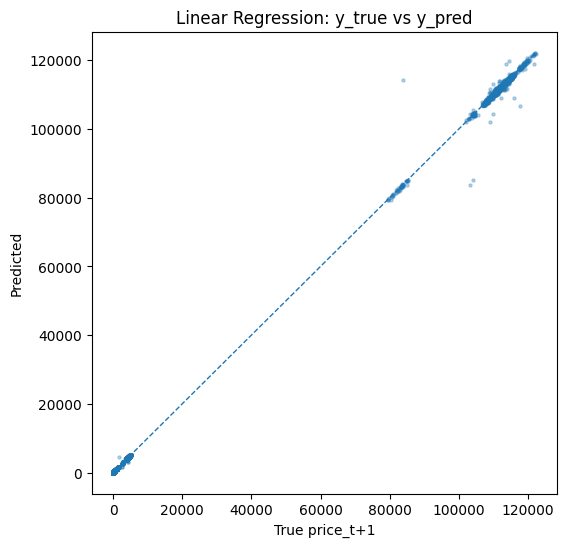

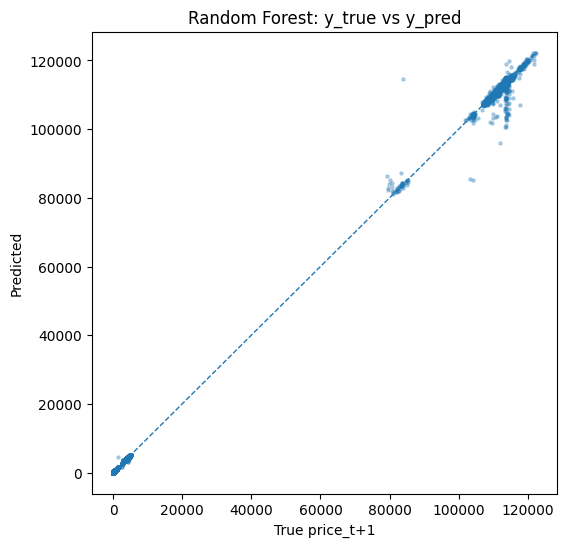

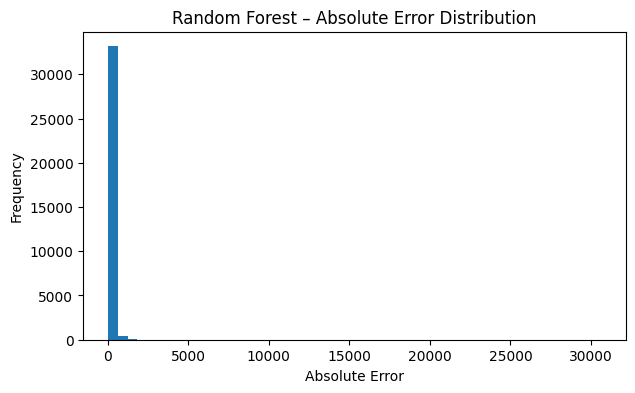

In [50]:
def scatter_true_pred(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=5, alpha=0.3)
    lims = [
        np.min([y_true.min(), y_pred.min()]),
        np.max([y_true.max(), y_pred.max()])
    ]
    plt.plot(lims, lims, '--', linewidth=1)
    plt.xlabel("True price_t+1")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

scatter_true_pred(y_test.values, pred_lr, "Linear Regression: y_true vs y_pred")
scatter_true_pred(y_test.values, pred_rf, "Random Forest: y_true vs y_pred")

# Phân phối sai số tuyệt đối RF
abs_err = np.abs(y_test.values - pred_rf)
plt.figure(figsize=(7,4))
plt.hist(abs_err, bins=50)
plt.title("Random Forest – Absolute Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()


In [51]:
# Thêm cột kết quả dự đoán và sai số
df_model.loc[test_mask, 'y_true_t+1'] = y_test
df_model.loc[test_mask, 'y_pred_rf'] = pred_rf
df_model.loc[test_mask, 'abs_err'] = (df_model['y_true_t+1'] - df_model['y_pred_rf']).abs()
df_model.loc[test_mask, 'pct_err'] = 100 * df_model['abs_err'] / df_model['y_true_t+1'].replace(0, np.nan)

# Tính MAE và MAPE cho từng crypto
perf_symbol = (
    df_model.loc[test_mask]
    .groupby('symbol')
    .agg(MAE=('abs_err', 'mean'),
         MAPE=('pct_err', 'mean'),
         Samples=('abs_err', 'count'))
    .sort_values('MAE')
)

print("📊 Top 10 crypto có MAE nhỏ nhất (mô hình dự đoán tốt nhất):")
display(perf_symbol.head(10).style.format({'MAE':'{:.2f}','MAPE':'{:.2f}%'}))

print("\n📊 Top 10 crypto có MAE lớn nhất (mô hình dự đoán kém nhất):")
display(perf_symbol.tail(10).style.format({'MAE':'{:.2f}','MAPE':'{:.2f}%'}))


📊 Top 10 crypto có MAE nhỏ nhất (mô hình dự đoán tốt nhất):


,MAE,MAPE,Samples
symbol,,,
pepe,0.00,nan%,95
shib,0.00,nan%,560
buidl,0.00,0.00%,22
usdc,0.00,0.00%,560
SHIB,0.00,1.65%,190
usdt0,0.00,0.00%,560
usds,0.00,0.00%,560
susde,0.00,0.00%,560
usdt,0.00,0.01%,560



📊 Top 10 crypto có MAE lớn nhất (mô hình dự đoán kém nhất):


,MAE,MAPE,Samples
symbol,,,
weeth,23.88,0.56%,560
wbeth,26.07,0.62%,560
steth,32.61,0.84%,560
eth,32.92,0.85%,560
weth,34.76,0.90%,560
ETH,96.17,3.51%,285
btc,566.90,0.51%,560
cbbtc,622.20,0.55%,560
wbtc,638.93,0.57%,560
